In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../src_jobs/')

In [4]:
import pickle
from itertools import repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from artifact import Saw_centered
from sliding_window_detector import SlidingWindowTransformerDetector, SlidingWindowLinearDetector, FineTunedSlidingWindowDetector, ConvolutionalSlidingWindowDetector

from data import CachedArtifactDataset, TestArtifactDataset, CenteredArtifactDataset

In [3]:
torch.set_grad_enabled(False)

In [10]:
test_width = 512
real_data = pd.read_pickle('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/real/francois_normalized_dataset.pickle') 

In [7]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

#autheticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient.from_config(
    credential=credential,
    path="config.json",
)

Found the config file in: config.json


In [8]:
import azure.ai.ml._artifacts._artifact_utilities as artifact_utils

data_asset = ml_client.data.get("artifactory_output", version="48")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
cnn_only = ConvolutionalSlidingWindowDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=500.ckpt").cpu()

data_asset = ml_client.data.get("artifactory_output", version="48")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
cnn_dense_635 = SlidingWindowLinearDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=48500-v1.ckpt").cpu()

data_asset = ml_client.data.get("artifactory_output", version="48")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
transformer_587 = SlidingWindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=48000.ckpt").cpu()

# data_asset = ml_client.data.get("artifactory_output", version="48")
# artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
# transformer_ft = FineTunedSlidingWindowDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/earlystop/epoch=0-step=18500.ckpt").cpu()


Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy 'https://m3mlopssadev.blob.core.windows.net/azureml-blobstore-206414f2-5a5c-4209-8dbe-6d0e233cd920/artifactory/earlystop/' './checkpoints_transformer/' 

See https://docs.microsoft.com/azure/storage/common/storage-use-azcopy-v10 for more information.
Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy 'https://m3mlopssadev.blob.core.windows.net/azureml-blobstore-206414f2-5a5c-4209-8dbe-6d0e233cd920/artifactory/earlystop/' './checkpoints_transformer/' 

See https://docs.microsoft.com/azure/storage/common/storage-use-azcopy-v10 for more information.
Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Exa

In [9]:
def baseline_detector(input: torch.Tensor) -> int:   
    input.squeeze(0)
    prediction = 0

    center = int(input.shape[1]/2)
    # flag points with very high increment as artifact
    # Calculate increments by subtracting the tensor shifted by one from the original tensor
    increments = (input[0][1:] - input[0][:-1]).abs()
    mean_increment = torch.mean(increments)
    print(mean_increment)
    std_increment = torch.std(increments)
    print(std_increment)
    print(increments[center-1])

    if increments[center-1] > (mean_increment + 3*std_increment):
        prediction = 1
        print('yes')
    else:
        print('no')
    
    # # flag highest/lowest point as artifact
    # # or better also with mean/std?
    # absolute_values = input.abs()
    # if input[0][center-1] > absolute_values.sort()[-3]:
    #     prediction = 1

    return prediction

In [ ]:
preds_baseline = list()
gt = list()

for sample in real_data:
    example = sample["data"]
    stride  = 64
    window  = test_width
    length  = len(example)

    example_data = torch.tensor(example + sample["artifact"])
    prediction_baseline = baseline_detector(example_data.unsqueeze(0))
    preds_baseline = preds_baseline + [prediction_baseline]

    gt = gt + [sample["label"]]


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix
import pandas as pd

metrics = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'mse'])
index = 0

preds_cnn_1 = list()
preds_cnn_2 = list()
preds_trans_1 = list()
#preds_trans_2 = list()
#preds_trans_ft = list()
preds_baseline = list()
gt = list()

for sample in real_data:
    example = sample["data"]
    stride  = 64
    window  = test_width
    length  = len(example)

    # add artifact to data
    example_data = torch.tensor(example)

    prediction_cnn_1 = cnn_only(example_data.unsqueeze(0))   
    prediction_cnn_2 = cnn_dense_635(example_data.unsqueeze(0))
    prediction_trans_1 = transformer_587(example_data.unsqueeze(0))
    #prediction_trans_2 = transformer_671(example_data.unsqueeze(0))
    #prediction_trans_ft = transformer_ft(example_data.unsqueeze(0))
    prediction_baseline = baseline_detector(example_data.unsqueeze(0))

    preds_cnn_1 = preds_cnn_1 + [prediction_cnn_1.numpy()]
    preds_cnn_2 = preds_cnn_2 + [prediction_cnn_2.numpy()]
    preds_trans_1 = preds_trans_1 + [prediction_trans_1.numpy()]
    #preds_trans_2 = preds_trans_2 + [prediction_trans_2.numpy()]
    #preds_trans_ft = preds_trans_ft + [prediction_trans_ft.numpy()]
    preds_baseline = preds_baseline + [prediction_baseline]

    gt = gt + [1]


tensor(0.1040)
tensor(0.2744)
tensor(0.0631)
no
tensor(0.1175)
tensor(0.2138)
tensor(0.1140)
no
tensor(0.1376)
tensor(0.2812)
tensor(0.1975)
no
tensor(0.1236)
tensor(0.2869)
tensor(0.1781)
no
tensor(0.0921)
tensor(0.2067)
tensor(0.1097)
no
tensor(0.1113)
tensor(0.2477)
tensor(0.1094)
no
tensor(0.1083)
tensor(0.2084)
tensor(0.1228)
no
tensor(0.1055)
tensor(0.2180)
tensor(0.1194)
no
tensor(0.1144)
tensor(0.2567)
tensor(0.2145)
no
tensor(0.1581)
tensor(0.3620)
tensor(0.1199)
no
tensor(0.1209)
tensor(0.2738)
tensor(0.1978)
no
tensor(0.1217)
tensor(0.2185)
tensor(0.0132)
no
tensor(0.1119)
tensor(0.2460)
tensor(0.0440)
no
tensor(0.1578)
tensor(0.3404)
tensor(0.2005)
no
tensor(0.1654)
tensor(0.3901)
tensor(0.1199)
no
tensor(0.1169)
tensor(0.2111)
tensor(0.0304)
no
tensor(0.1267)
tensor(0.2681)
tensor(0.1655)
no
tensor(0.1394)
tensor(0.3031)
tensor(0.3875)
no
tensor(0.1236)
tensor(0.2930)
tensor(0.1059)
no
tensor(0.1086)
tensor(0.2148)
tensor(0.0725)
no
tensor(0.1015)
tensor(0.2041)
tensor(0.0

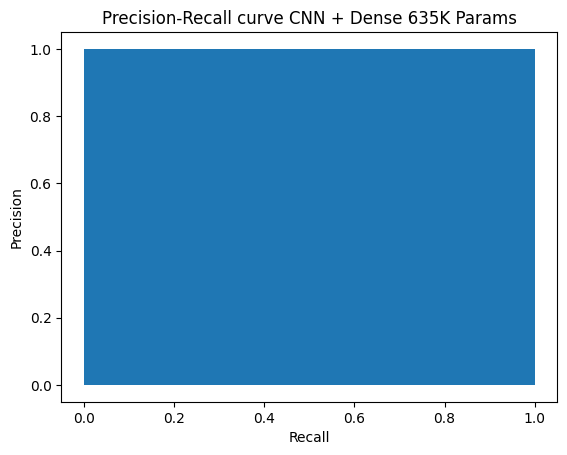

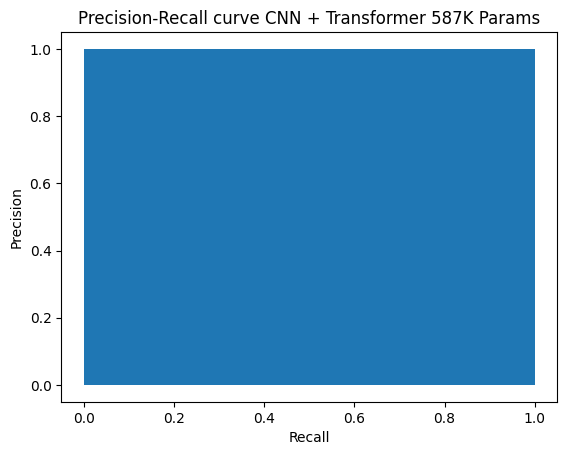

NameError: name 'preds_trans_ft' is not defined

In [15]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(gt, preds_cnn_1)
J = precision + recall
ix = np.argmax(J)
best_thresh_pr_cnn1 = thresholds[ix]

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve CNN + Dense 635K Params")
plt.show()

# precision, recall, thresholds = precision_recall_curve(gt, preds_cnn_2)
# J = precision + recall
# ix = np.argmax(J)
# best_thresh_pr = thresholds[ix]

precision, recall, thresholds = precision_recall_curve(gt, preds_trans_1)
J = precision + recall
ix = np.argmax(J)
best_thresh_pr = thresholds[ix]

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve CNN + Transformer 587K Params")
plt.show()

# precision, recall, thresholds = precision_recall_curve(gt, preds_trans_2)
# J = precision + recall
# ix = np.argmax(J)
# best_thresh_pr = thresholds[ix]

precision, recall, thresholds = precision_recall_curve(gt, preds_trans_ft)
J = precision + recall
ix = np.argmax(J)
best_thresh_pr = thresholds[ix]

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve CNN + Transformer Fine Tuning 587K Params")
plt.show()

precision, recall, thresholds = precision_recall_curve(gt, preds_baseline)
J = precision + recall
ix = np.argmax(J)
best_thresh_pr = thresholds[ix]

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve Baseline 0 Params")
plt.show()


In [16]:
from sklearn.metrics import fbeta_score

max_fbeta = 0

for threshold in np.linspace(0,  1,  100):
    predictions_cnn_1 = np.where(preds_cnn_1 > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions_cnn_1, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_cnn_1 = threshold

max_fbeta = 0

for threshold in np.linspace(0,  1,  100):
    predictions_cnn_2 = np.where(preds_cnn_2 > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions_cnn_2, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_cnn_2 = threshold


max_fbeta = 0

for threshold in np.linspace(0,  1,  100):
    predictions_trans_1 = np.where(preds_trans_1 > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions_trans_1, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_trans_1 = threshold

max_fbeta = 0

# for threshold in np.linspace(0,  1,  100):
#     predictions_trans_2 = np.where(preds_trans_2 > threshold, 1, 0)

#     fbeta = fbeta_score(gt, predictions_trans_2, average='macro', beta=0.5)

#     if (fbeta > max_fbeta):
#         max_fbeta = fbeta
#         best_threshold_fbeta_trans_2 = threshold

# max_fbeta = 0

# for threshold in np.linspace(0,  1,  100):
#     predictions_trans_ft = np.where(preds_trans_ft > threshold, 1, 0)

#     fbeta = fbeta_score(gt, predictions_trans_ft, average='macro', beta=0.5)

#     if (fbeta > max_fbeta):
#         max_fbeta = fbeta
#         best_threshold_fbeta_ft = threshold

# max_fbeta = 0


In [30]:
best_threshold_fbeta_cnn_1 = 0.5
best_threshold_fbeta_cnn_2 = 0.2
best_threshold_fbeta_trans_1 = 0.2

In [31]:
preds_binary_cnn_1 = [1 if value >= best_threshold_fbeta_cnn_1 else 0 for value in preds_cnn_1]
preds_binary_cnn_2 = [1 if value >= best_threshold_fbeta_cnn_2 else 0 for value in preds_cnn_2]
preds_binary_trans_1 = [1 if value >= best_threshold_fbeta_trans_1 else 0 for value in preds_trans_1]
#preds_binary_trans_2 = [1 if value >= best_threshold_fbeta_trans_2 else 0 for value in preds_trans_2]
#preds_binary_trans_ft = [1 if value >= best_threshold_fbeta_ft else 0 for value in preds_trans_ft]
preds_binary_baseline = preds_baseline

tn_cnn_1, fp_cnn_1, fn_cnn_1, tp_cnn_1 = confusion_matrix(gt, preds_binary_cnn_1, labels=[0, 1]).ravel()
tn_cnn_2, fp_cnn_2, fn_cnn_2, tp_cnn_2 = confusion_matrix(gt, preds_binary_cnn_2, labels=[0, 1]).ravel()
tn_trans_1, fp_trans_1, fn_trans_1, tp_trans_1 = confusion_matrix(gt, preds_binary_trans_1, labels=[0, 1]).ravel()
#tn_trans_2, fp_trans_2, fn_trans_2, tp_trans_2 = confusion_matrix(gt, preds_binary_trans_2, labels=[0, 1]).ravel()
#tn_trans_ft, fp_trans_ft, fn_trans_ft, tp_trans_ft = confusion_matrix(gt, preds_binary_trans_ft, labels=[0, 1]).ravel()
tn_baseline, fp_baseline, fn_baseline, tp_baseline = confusion_matrix(gt, preds_binary_baseline, labels=[0, 1]).ravel()

metrics = pd.DataFrame([{
    'detector': 'cnn_only',
    'threshold': best_threshold_fbeta_cnn_1,
    'accuracy': accuracy_score(gt, preds_binary_cnn_1),
    'precision': precision_score(gt, preds_binary_cnn_1),
    'recall': recall_score(gt, preds_binary_cnn_1),
    'fbeta': fbeta_score(gt, preds_binary_cnn_1, beta=0.5),
    'mse': mean_squared_error(gt, preds_binary_cnn_1),
    'tn': tn_cnn_1,
    'fp': fp_cnn_1, 
    'fn': fn_cnn_1, 
    'tp': tp_cnn_1,
},
{
    'detector': 'cnn_dense_635K',
    'threshold': best_threshold_fbeta_cnn_2,
    'accuracy': accuracy_score(gt, preds_binary_cnn_2),
    'precision': precision_score(gt, preds_binary_cnn_2),
    'recall': recall_score(gt, preds_binary_cnn_2),
    'fbeta': fbeta_score(gt, preds_binary_cnn_2, beta=0.5),
    'mse': mean_squared_error(gt, preds_binary_cnn_2),
    'tn': tn_cnn_2,
    'fp': fp_cnn_2, 
    'fn': fn_cnn_2, 
    'tp': tp_cnn_2
},
{
    'detector': 'transformer_587K',
    'threshold': best_threshold_fbeta_trans_1,
    'accuracy': accuracy_score(gt, preds_binary_trans_1),
    'precision': precision_score(gt, preds_binary_trans_1),
    'recall': recall_score(gt, preds_binary_trans_1),
    'fbeta': fbeta_score(gt, preds_binary_trans_1, beta=0.5),
    'mse': mean_squared_error(gt, preds_binary_trans_1),
    'tn': tn_trans_1,
    'fp': fp_trans_1, 
    'fn': fn_trans_1, 
    'tp': tp_trans_1
},
# {
#     'detector': 'transformer_671K',
#     'threshold': best_threshold_fbeta_trans_2,
#     'accuracy': accuracy_score(gt, preds_binary_trans_2),
#     'precision': precision_score(gt, preds_binary_trans_2),
#     'recall': recall_score(gt, preds_binary_trans_2),
#     'mse': mean_squared_error(gt, preds_binary_trans_2),
#     'tn': tn_trans_2,
#     'fp': fp_trans_2, 
#     'fn': fn_trans_2, 
#     'tp': tp_trans_2
# },    
# {
#     'detector': 'ft_transformer_587K',
#     'threshold': best_threshold_fbeta_ft,
#     'accuracy': accuracy_score(gt, preds_binary_trans_ft),
#     'precision': precision_score(gt, preds_binary_trans_ft),
#     'recall': recall_score(gt, preds_binary_trans_ft),
#     'mse': mean_squared_error(gt, preds_binary_trans_ft),
#     'tn': tn_trans_ft,
#     'fp': fp_trans_ft, 
#     'fn': fn_trans_ft, 
#     'tp': tp_trans_ft
# },
{
    'detector': 'baseline',
    'threshold': 0.5,
    'accuracy': accuracy_score(gt, preds_binary_baseline),
    'precision': precision_score(gt, preds_binary_baseline),
    'recall': recall_score(gt, preds_binary_baseline),
    'fbeta': fbeta_score(gt, preds_binary_baseline, beta=0.5),
    'mse': mean_squared_error(gt, preds_binary_baseline),
    'tn': tn_baseline,
    'fp': fp_baseline, 
    'fn': fn_baseline, 
    'tp': tp_baseline
}])

/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
metrics

,detector,threshold,accuracy,precision,recall,fbeta,mse,tn,fp,fn,tp
0,cnn_only,0.5,1.000000,1.0,1.000000,1.000000,0.000000,0,0,0,81
1,cnn_dense_635K,0.2,0.345679,1.0,0.345679,0.725389,0.654321,0,0,53,28
2,transformer_587K,0.2,0.469136,1.0,0.469136,0.815451,0.530864,0,0,43,38
3,baseline,0.5,0.000000,0.0,0.000000,0.000000,1.000000,0,0,81,0


In [13]:
best_thresh_pr

0.48818028

In [ ]:
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Validation Precision-Recall curve")

In [18]:
best_threshold_fbeta

0.5252525252525253

In [ ]:
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Validation Precision-Recall curve")

In [20]:
df = pd.DataFrame({
    'index': range(len(val)),
    'gt': gt,
    'predictions': preds_binary
})

In [ ]:
# Create the bar plot
plt.hist(preds_trans, bins=10)

# Customize the plot (optional)
plt.title("Predictions on synthetic validation set")

# Display the plot
plt.show()

In [21]:
# get indices of samples
fp_ind = (df.loc[(df['gt'] == 0) & (df['predictions'] == 1)])["index"]
fn_ind = (df.loc[(df['gt'] == 1) & (df['predictions'] == 0)])["index"]
tn_ind = (df.loc[(df['gt'] == 0) & (df['predictions'] == 0)])["index"]
tp_ind = (df.loc[(df['gt'] == 1) & (df['predictions'] == 1)])["index"]

In [ ]:
import matplotlib

for index in tp_ind[10:20]:
    sample = val[int(index)]
    label = sample["label"]
    example = torch.tensor(sample["data"] + sample["artifact"])

    length  = len(example)

    prediction_trans = transformer_detector(example.unsqueeze(0))

    plt.figure(figsize=(10, 6.666))
    plt.plot(example, label="data", c="blue", linewidth=3.0)
    plt.axvline(x=256, c="red", linestyle="--", linewidth=3.0, dashes=(4,4), label="position of artifact")
    # changing the fontsize of yticks
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel("#Time steps [a.u.]", fontsize=20)
    plt.ylabel("Power [a.u.]", fontsize=20)
    # to set the font size of the legend 
    # plt.title(f"Label: {label}, prediction: {prediction_trans}, sample number {int(index)}")
    #plt.title(f"Sliding Window detector, artifact in the middle: {label}")
    # to set the font size of the legend 
    matplotlib.rcParams['legend.fontsize'] = 15
    plt.legend(loc='best')
    plt.show()